<a href="https://colab.research.google.com/github/ManuSanchez02/7506R-2c2022-GRUPO09/blob/main/tp2/7506R_TP2_GRUPO09_ENTREGA_N2_(redes_neuronales).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Configuración inicial

Importamos e instalamos las bibliotecas necesarias.

In [19]:
!pip install keras_tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing

import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt
from keras.models import Sequential
from keras.layers.core import Dense  
from sklearn.metrics import (
    confusion_matrix,
    recall_score, 
    accuracy_score, 
    f1_score,
    mean_squared_error,
    r2_score,
)
from sklearn.model_selection import KFold
from keras.losses import sparse_categorical_crossentropy
from keras.optimizers import Adam

np.random.seed(1)
tf.random.set_seed(1)

### Funciones útiles

In [21]:
def graficar_matriz_de_confusion(y_test, y_pred, labels):
    cm = confusion_matrix(y_test, y_pred)
    fig = plt.figure(figsize = (12, 10))
    sns.heatmap(
        cm, annot=True, xticklabels=labels, yticklabels=labels, cmap="GnBu", fmt="g"
    )
    plt.title("Matriz de confusión")
    plt.xlabel("Predichos")
    plt.ylabel("Verdaderos")
    plt.show()

def imprimir_metricas_de_clasificacion(y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred, average="weighted")
    f1 = f1_score(y_test, y_pred, average="weighted")

    print("\nMétricas de clasificación\n")
    print("Accuracy: " + str(accuracy))
    print("Recall: " + str(recall))
    print("F1 score: " + str(f1))

def imprimir_metricas_de_regresion(target_test, precios_predichos):
    # Error cuadrático medio
    mse = mean_squared_error(
        y_true=target_test, y_pred=precios_predichos, squared=True
    )

    # Raíz del error cuadrático medio
    rmse = mean_squared_error(
        y_true=target_test, y_pred=precios_predichos, squared=False
    )

    # Score R2
    r2 = r2_score(target_test, precios_predichos)

    print("\nMétricas de regresión\n")
    print(f"El error (mse) de test es: {mse}")
    print(f"El error (rmse) de test es: {rmse}")
    print(f"El score R2 es: {r2}")

Importamos los datasets que se utilizarán para trabajar.

In [22]:
dataset_train_clasificacion = pd.read_csv("https://github.com/ManuSanchez02/7506R-2c2022-GRUPO09/blob/main/tp2/datasets/clasificacion_train_feature.csv?raw=True")
dataset_test_clasificacion = pd.read_csv("https://github.com/ManuSanchez02/7506R-2c2022-GRUPO09/blob/main/tp2/datasets/clasificacion_test_feature.csv?raw=True")

dataset_train_regresion = pd.read_csv("https://github.com/ManuSanchez02/7506R-2c2022-GRUPO09/blob/main/tp2/datasets/regresion_train_feature.csv?raw=True")
dataset_test_regresion = pd.read_csv("https://github.com/ManuSanchez02/7506R-2c2022-GRUPO09/blob/main/tp2/datasets/regresion_test_feature.csv?raw=True")

In [23]:
y_train_clasificacion_categorico = pd.read_csv("https://github.com/ManuSanchez02/7506R-2c2022-GRUPO09/blob/main/tp2/datasets/clasificacion_train_target.csv?raw=True")
y_test_clasificacion_categorico = pd.read_csv("https://github.com/ManuSanchez02/7506R-2c2022-GRUPO09/blob/main/tp2/datasets/clasificacion_test_target.csv?raw=True")

y_train_regresion = pd.read_csv("https://github.com/ManuSanchez02/7506R-2c2022-GRUPO09/blob/main/tp2/datasets/regresion_train_target.csv?raw=True")
y_test_regresion = pd.read_csv("https://github.com/ManuSanchez02/7506R-2c2022-GRUPO09/blob/main/tp2/datasets/regresion_test_target.csv?raw=True")


In [24]:
def preparar_dataset(dataset):
  dataset.drop("Unnamed: 0", axis = 1, inplace=True)
  dataset.drop("id", axis = 1, inplace=True)
  return dataset

def preparar_target(target):
  target.drop("Unnamed: 0", axis = 1, inplace=True)
  return target

dataset_train_clasificacion = preparar_dataset(dataset_train_clasificacion)
dataset_test_clasificacion = preparar_dataset(dataset_test_clasificacion)
dataset_train_regresion = preparar_dataset(dataset_train_regresion)
dataset_test_regresion = preparar_dataset(dataset_test_regresion)

y_train_clasificacion_categorico = preparar_target(y_train_clasificacion_categorico)
y_test_clasificacion_categorico = preparar_target(y_test_clasificacion_categorico)
y_train_regresion = preparar_target(y_train_regresion)
y_test_regresion = preparar_target(y_test_regresion)

Convertimos las categorías del target de clasificación en categorías numéricas para poder utilizarlas en la red neuronal.

In [25]:
le = preprocessing.LabelEncoder()
y_train_clasificacion = le.fit_transform(y_train_clasificacion_categorico)
y_test_clasificacion = le.transform(y_test_clasificacion_categorico)


/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


# Redes neuronales

Escalamos los datos para que performe mejor.

In [26]:
scaler_clasificacion = StandardScaler()
scaler_clasificacion.fit(dataset_train_clasificacion)

scaler_regresion = StandardScaler()
scaler_regresion.fit(dataset_train_regresion)

StandardScaler()

In [27]:
x_train_clasificacion = scaler_clasificacion.transform(dataset_train_clasificacion)
x_test_clasificacion = scaler_clasificacion.transform(dataset_test_clasificacion)

x_train_regresion = scaler_regresion.transform(dataset_train_regresion)
x_test_regresion = scaler_regresion.transform(dataset_test_regresion)


## Clasificación

Definimos las salidas del modelo.

In [28]:
outputs = {
    "bajo": 0,
    "medio": 1,
    "alto": 2,
}

Creamos el modelo secuencial de Keras.

In [39]:
def build_model(hp):
  model = keras.Sequential()
  model.add(keras.layers.Dense(
      hp.Int('units', min_value=32, max_value=512, step=16),
      activation=hp.Choice("activation", ["relu", "tanh"])))
  model.add(keras.layers.Dense(10, activation="tanh"))
  model.add(keras.layers.Dense(3, activation="softmax"))
  learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-1, sampling="log")

  model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False), 
                optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
                metrics=["accuracy"])
  return model

Hacemos un Randomized Search para buscar los mejores hiperparámetros.

In [42]:
tuner = kt.RandomSearch(
    build_model,
    objective='loss',
    max_trials=10,
    project_name="Clasificacion",
    overwrite=True)

In [44]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=1)
tuner.search(x_train_clasificacion, y_train_clasificacion, epochs=100, validation_split=0.2, callbacks=[stop_early])
best_model = tuner.get_best_models()[0]


Trial 10 Complete [00h 00m 31s]
loss: 0.8263664841651917

Best loss So Far: 0.8020757436752319
Total elapsed time: 00h 06m 13s


Imprimimos los resultados del mejor modelo obtenido.

In [57]:
best_hps = tuner.get_best_hyperparameters()[0]
best_hps.values

{'units': 496, 'activation': 'tanh', 'lr': 0.00046002804367732453}

In [59]:
best_model = build_model(best_hps)
best_model.fit(x=x_train_clasificacion, y=y_train_clasificacion, epochs=500)

Epoch 1/500
2163/2163 [==============================] - 7s 2ms/step - loss: 0.8633 - accuracy: 0.5845
Epoch 2/500
2163/2163 [==============================] - 5s 2ms/step - loss: 0.8333 - accuracy: 0.5998
Epoch 3/500
2163/2163 [==============================] - 5s 2ms/step - loss: 0.8243 - accuracy: 0.6036
Epoch 4/500
2163/2163 [==============================] - 5s 2ms/step - loss: 0.8171 - accuracy: 0.6073
Epoch 5/500
2163/2163 [==============================] - 5s 2ms/step - loss: 0.8122 - accuracy: 0.6077
Epoch 6/500
2163/2163 [==============================] - 5s 2ms/step - loss: 0.8082 - accuracy: 0.6105
Epoch 7/500
2163/2163 [==============================] - 5s 2ms/step - loss: 0.8054 - accuracy: 0.6107
Epoch 8/500
2163/2163 [==============================] - 5s 2ms/step - loss: 0.8036 - accuracy: 0.6121
Epoch 9/500
2163/2163 [==============================] - 5s 2ms/step - loss: 0.8013 - accuracy: 0.6113
Epoch 10/500
2163/2163 [==============================] - 5s 2ms/step - l

Generamos las predicciones para train y vemos cómo performa.

In [60]:
def clasificar_propiedad(model, entrada):
  prediccion = model.predict(entrada)
  arg_max = np.argmax(prediccion, axis=1)
  return arg_max

2163/2163 [==============================] - 3s 1ms/step


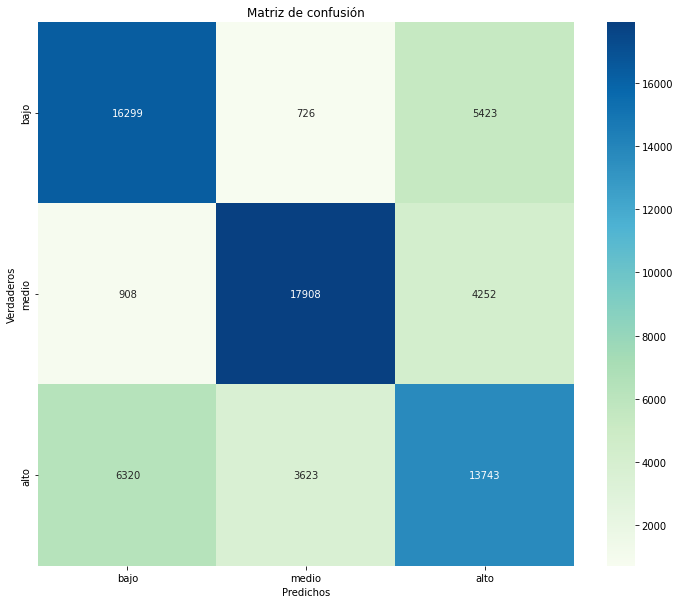


Métricas de clasificación

Accuracy: 0.6928990491604289
Recall: 0.6928990491604289
F1 score: 0.6931316050718525


In [61]:
y_pred = clasificar_propiedad(best_model, x_train_clasificacion)
graficar_matriz_de_confusion(y_train_clasificacion, y_pred, outputs.keys())
imprimir_metricas_de_clasificacion(y_train_clasificacion, y_pred)

Vemos cómo performa con los datos de test.

540/540 [==============================] - 1s 1ms/step


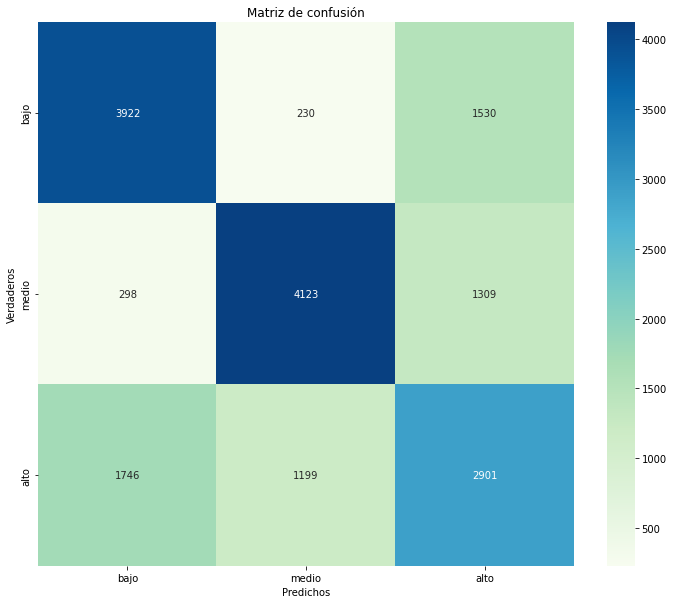


Métricas de clasificación

Accuracy: 0.6342565766600997
Recall: 0.6342565766600997
F1 score: 0.6340227995538984


In [62]:
y_pred = clasificar_propiedad(best_model, x_test_clasificacion)
graficar_matriz_de_confusion(y_test_clasificacion, y_pred, outputs.keys())
imprimir_metricas_de_clasificacion(y_test_clasificacion, y_pred)


## Regresión

Construimos el modelo.

In [63]:
d_in = x_train_regresion.shape[1]
d_out = 1

In [66]:
def build_model(hp):
  model = keras.Sequential()
  model.add(keras.layers.Dense(
      hp.Int('units', min_value=32, max_value=512, step=16),
      activation=hp.Choice("activation", ["relu", "tanh"]), input_shape=(d_in,)))
  model.add(Dense(128, activation='relu'))
  model.add(Dense(32, activation='relu'))
  model.add(Dense(d_out))
  learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-1, sampling="log")

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), 
  loss = 'mse', 
  metrics = ['mse'],)
  return model

Buscamos los mejores hiperparámetros.

In [67]:
tuner = kt.RandomSearch(
    build_model,
    objective='loss',
    max_trials=10,
    project_name="Regresion",
    overwrite=True)

In [68]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=1)
tuner.search(x_train_clasificacion, y_train_clasificacion, epochs=100, validation_split=0.2, callbacks=[stop_early])
best_model = tuner.get_best_models()[0]

Trial 10 Complete [00h 00m 29s]
loss: 0.5874912738800049

Best loss So Far: 0.587153971195221
Total elapsed time: 00h 03m 50s


Imprimimos los mejores hiperparámetros encontrados y entrenamos nuevamente al modelo.

In [69]:
best_hps = tuner.get_best_hyperparameters()[0]
best_hps.values

{'units': 224, 'activation': 'relu', 'lr': 0.00010700549249923322}

In [70]:
best_model = build_model(best_hps)
best_model.fit(x=x_train_regresion, y=y_train_regresion, epochs=500)

Epoch 1/500
2163/2163 [==============================] - 6s 3ms/step - loss: 32732413952.0000 - mse: 32732413952.0000
Epoch 2/500
2163/2163 [==============================] - 5s 2ms/step - loss: 6488169984.0000 - mse: 6488169984.0000
Epoch 3/500
2163/2163 [==============================] - 6s 3ms/step - loss: 3065523968.0000 - mse: 3065523968.0000
Epoch 4/500
2163/2163 [==============================] - 6s 3ms/step - loss: 2878243584.0000 - mse: 2878243584.0000
Epoch 5/500
2163/2163 [==============================] - 5s 3ms/step - loss: 2804150016.0000 - mse: 2804150016.0000
Epoch 6/500
2163/2163 [==============================] - 5s 3ms/step - loss: 2758620160.0000 - mse: 2758620160.0000
Epoch 7/500
2163/2163 [==============================] - 6s 3ms/step - loss: 2727923712.0000 - mse: 2727923712.0000
Epoch 8/500
2163/2163 [==============================] - 6s 3ms/step - loss: 2705176320.0000 - mse: 2705176320.0000
Epoch 9/500
2163/2163 [==============================] - 6s 3ms/step -

Generamos las predicciones para train y vemos cómo performa.

In [73]:
y_pred_regresion = best_model.predict(x_train_regresion)
imprimir_metricas_de_regresion(y_train_regresion, y_pred_regresion)

2163/2163 [==============================] - 3s 1ms/step

Métricas de regresión

El error (mse) de test es: 1965073952.8753333
El error (rmse) de test es: 44329.1546600579
El score R2 es: 0.8167946762967582


Ahora lo probamos con los datos de test.

In [74]:
y_pred_regresion = best_model.predict(x_test_regresion)
imprimir_metricas_de_regresion(y_test_regresion, y_pred_regresion)

540/540 [==============================] - 1s 1ms/step

Métricas de regresión

El error (mse) de test es: 2076981265.8100636
El error (rmse) de test es: 45573.90992453976
El score R2 es: 0.8044855283509453


## Conclusiones

Las redes neuronales son muy poderosas pero el hecho de que su entrenamiento sea lento y la búsqueda de hiperparámetros tenga que ser manual hace que no podamos sacarle el provecho completo.

En comparación, XGBoost tiene mejores métricas en menos tiempo, y nos permite hacer una mejor búsqueda de hiperparámetros, por lo que para nuestros objetivos nos sirve más.